# Test for AI to learn how temperture works at my place

based on : https://www.tensorflow.org/tutorials/structured_data/time_series

**I HAVE NO IDEA WHAT I AM DOING, THIS IS NOT A TUTORIAL, I AM JUST FOOLING AROUND TRYING TO COMPREHEND THE INSANITY THAT IS AI AND ML**

Here we import all the things we need : 

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Some config i guess 

In [2]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

here we read the csv file

In [3]:
df = pd.read_csv("Stats.csv")

We make sure that all our colums do not have null values

In [4]:
df.isnull().any() 

ID                False
Date              False
InsideTemp        False
InsideHumidity    False
dtype: bool

We drop if there are some values that are missing (this doesnt realy seam to work, mabey i need to reassign the value?)

In [5]:
df.dropna()

,ID,Date,InsideTemp,InsideHumidity
0,1,2019-04-15 20:07:10,23.87,30.67
1,2,2019-04-15 20:08:10,23.55,28.65
2,3,2019-04-15 20:09:12,23.17,29.22
3,4,2019-04-15 20:10:13,22.85,29.58
4,5,2019-04-15 20:11:15,22.62,29.91
...,...,...,...,...
488618,493146,2020-09-01 19:04:45,27.23,37.70
488619,493147,2020-09-01 19:05:45,27.00,38.14
488620,493148,2020-09-01 19:06:45,26.92,38.42
488621,493149,2020-09-01 19:07:45,26.89,38.57


slice [start:stop:step], starting from index 5 take every 6th record. (this is to transform to hours (i think ?))

In [ ]:
df = df[5::6]

here we transform the date so it is readable format by the machine (i think at least ?)

In [7]:
date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d %H:%M:%S')

Show the first 5 rows 

In [8]:
df.head()

,ID,InsideTemp,InsideHumidity
5,6,22.42,30.10
11,12,21.87,30.96
17,18,21.65,31.36
23,24,21.53,31.50
29,30,21.48,31.75


choose what headers from the csv we want to see

In [9]:
plot_cols = ['InsideTemp', 'InsideHumidity']

Plot (make a graph) of all the values

In [10]:
plot_features = df[plot_cols]

Choose what the index is

In [11]:
plot_features.index = date_time

make a plot "subplots=True" makes one graph for each value

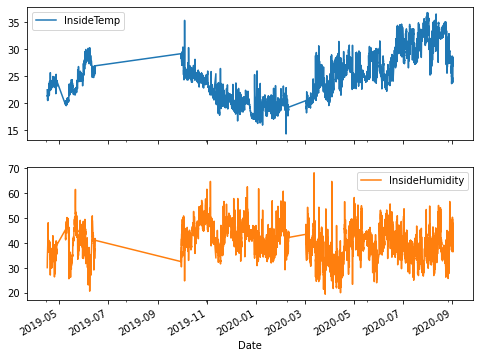

In [12]:
_ = plot_features.plot(subplots=True)

This also makes a plot but this tome we are only looking at the first 350 values (also an example of th subplot to false)

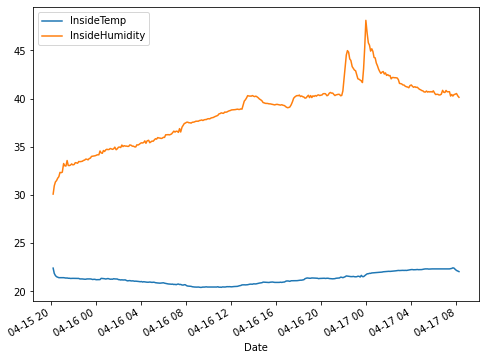

In [13]:
plot_features = df[plot_cols][:350]
plot_features.index = date_time[:350]
_ = plot_features.plot(subplots=False)

Have a look at the satistics (this function is pretty impressive i have to admit)

In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,81437.0,245306.333325,142335.663081,6.00,122161.00,244315.00,368330.00,493149.00
InsideTemp,81437.0,24.646281,4.450581,14.23,20.83,24.42,27.54,36.72
InsideHumidity,81437.0,40.012916,5.771816,19.44,36.11,39.71,44.20,68.17


lets make some graphs (this one is a little useless but at least i see how t command works)

Text(0, 0.5, 'InsideHumidity')

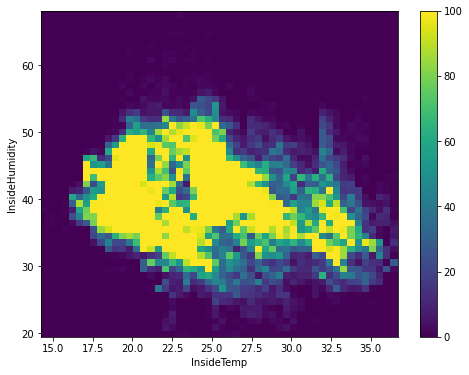

In [15]:
# creata a 2D heatmap
plt.hist2d(df['InsideTemp'], df['InsideHumidity'], bins=(50, 50), vmax=100)
#activate the color bar
plt.colorbar()
#set the X axis label
plt.xlabel('InsideTemp') 
#set he Y  axis label
plt.ylabel('InsideHumidity')

to make it easier for the machine, we are going to transform the time stamp
we start by transforming it into senconds

In [16]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [17]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

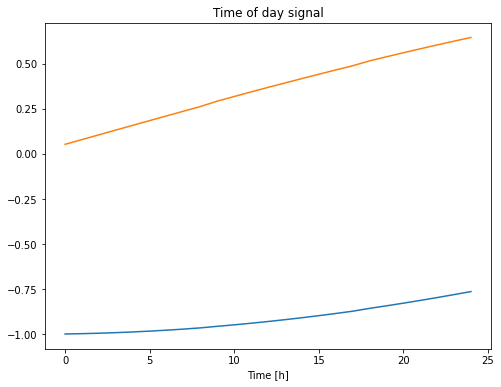

In [18]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

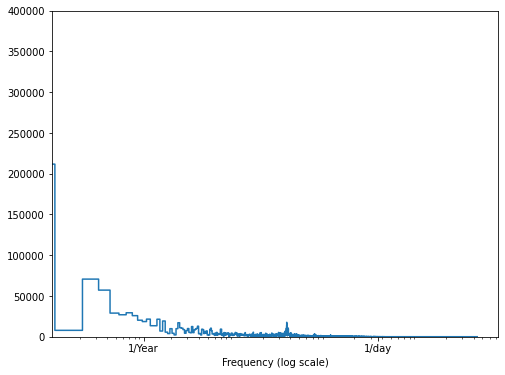

In [19]:
fft = tf.signal.rfft(df['InsideTemp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['InsideTemp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [20]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [21]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

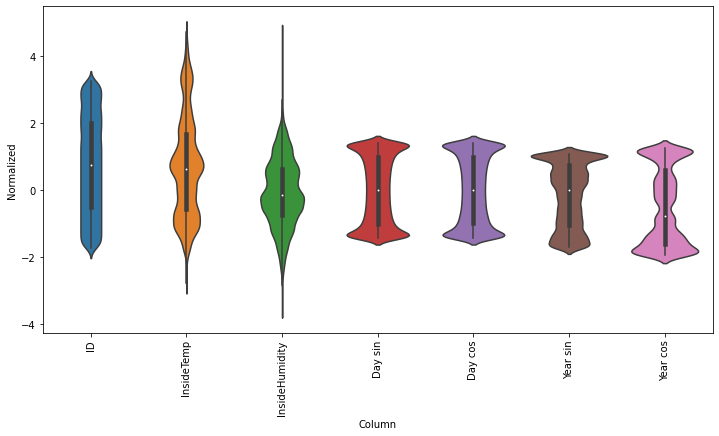

In [22]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [23]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [24]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['InsideTemp'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['InsideTemp']

In [25]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['InsideTemp'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['InsideTemp']

In [26]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [27]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 7)
Inputs shape: (3, 6, 7)
labels shape: (3, 1, 1)


In [28]:
w2.example = example_inputs, example_labels

In [29]:
def plot(self, model=None, plot_col='InsideTemp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

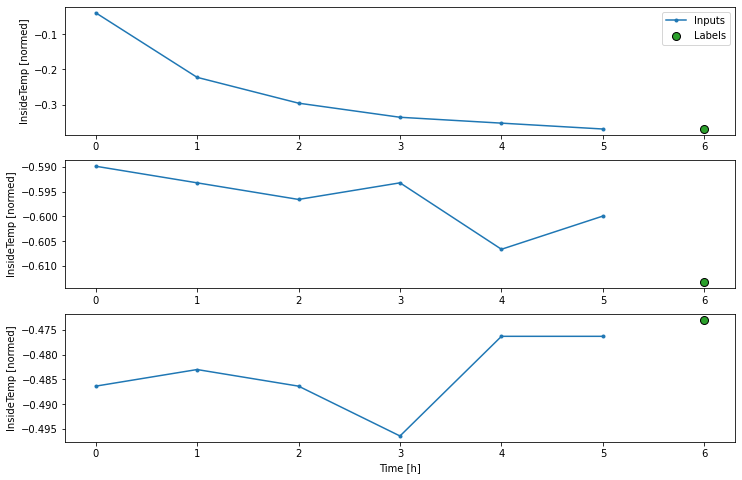

In [30]:
w2.plot()

In [31]:
#w2.plot(plot_col='InsideHumidity')

I think we are getting in th real AI part here

We make the dataset

In [32]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [33]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [34]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [35]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [36]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['InsideTemp'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['InsideTemp']

## Single step Models
The easisest to build , here we are going to predict one hour in the future, only based on the current conditions

### Baseline

In [37]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [38]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [39]:
baseline = Baseline(label_index=column_indices['InsideTemp'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

509/509 [==============================] - 1s 1ms/step - loss: 0.0011 - mean_absolute_error: 0.0172


In [40]:
wide_window = WindowGenerator(
    input_width=15, label_width=15, shift=1,
    label_columns=['InsideTemp'])

wide_window

Total window size: 16
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label column name(s): ['InsideTemp']

In [41]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


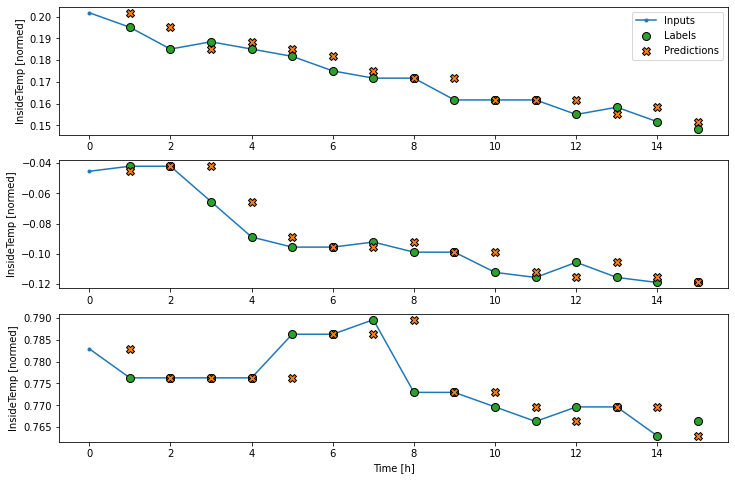

In [42]:
wide_window.plot(baseline)

### Linear model

In [43]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [44]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


In [45]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [46]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1782/1782 [==============================] - 3s 2ms/step - loss: 0.3740 - mean_absolute_error: 0.3908 - val_loss: 0.0738 - val_mean_absolute_error: 0.2498
Epoch 2/20
1782/1782 [==============================] - 3s 2ms/step - loss: 0.0038 - mean_absolute_error: 0.0408 - val_loss: 0.0028 - val_mean_absolute_error: 0.0413
Epoch 3/20
1782/1782 [==============================] - 2s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0142 - val_loss: 0.0012 - val_mean_absolute_error: 0.0201
Epoch 4/20
1782/1782 [==============================] - 3s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0136 - val_loss: 0.0013 - val_mean_absolute_error: 0.0209
Epoch 5/20
1782/1782 [==============================] - 3s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0138 - val_loss: 0.0012 - val_mean_absolute_error: 0.0187
Epoch 6/20
1782/1782 [==============================] - 3s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0139 - val_loss: 0.0013 - val_mean_absolute_error: 0.0219
Epoc

In [47]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 15, 7)
Output shape: (32, 15, 1)


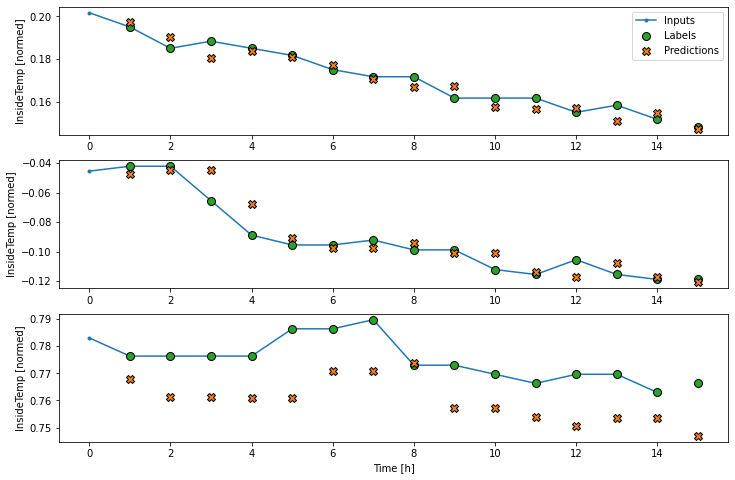

In [48]:
wide_window.plot(linear)

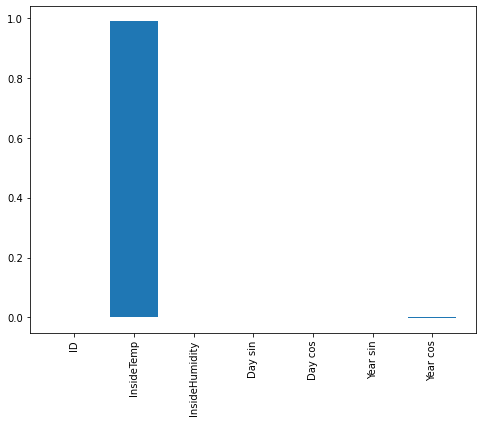

In [49]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Dense

In [50]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
1782/1782 [==============================] - 3s 2ms/step - loss: 0.0108 - mean_absolute_error: 0.0423 - val_loss: 0.0090 - val_mean_absolute_error: 0.0762
Epoch 2/20
1782/1782 [==============================] - 3s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0240 - val_loss: 0.0059 - val_mean_absolute_error: 0.0601
Epoch 3/20
1782/1782 [==============================] - 3s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0227 - val_loss: 0.0037 - val_mean_absolute_error: 0.0460
Epoch 4/20
1782/1782 [==============================] - 4s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0217 - val_loss: 0.0031 - val_mean_absolute_error: 0.0402
Epoch 5/20
1782/1782 [==============================] - 3s 2ms/step - loss: 0.0015 - mean_absolute_error: 0.0210 - val_loss: 0.0025 - val_mean_absolute_error: 0.0355
Epoch 6/20
1782/1782 [==============================] - 3s 2ms/step - loss: 0.0015 - mean_absolute_error: 0.0202 - val_loss: 0.0020 - val_mean_absolute_error: 0.0300
Epoc

In [51]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 15, 7)
Output shape: (32, 15, 1)


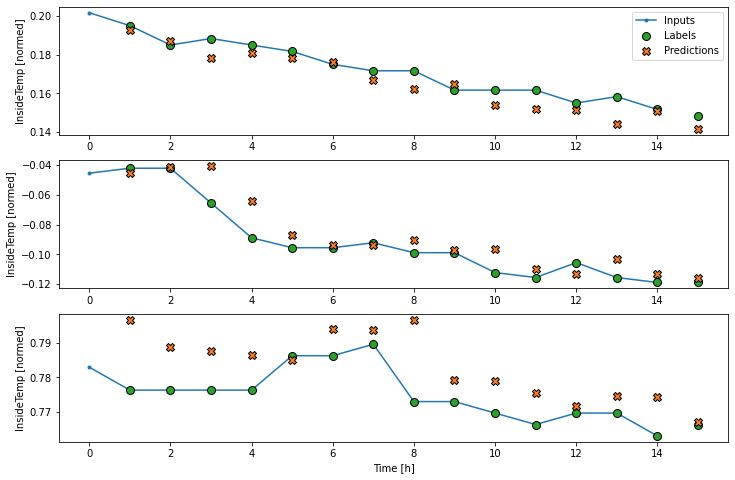

In [52]:
wide_window.plot(dense)

### Multi-step dense

In [53]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['InsideTemp'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['InsideTemp']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

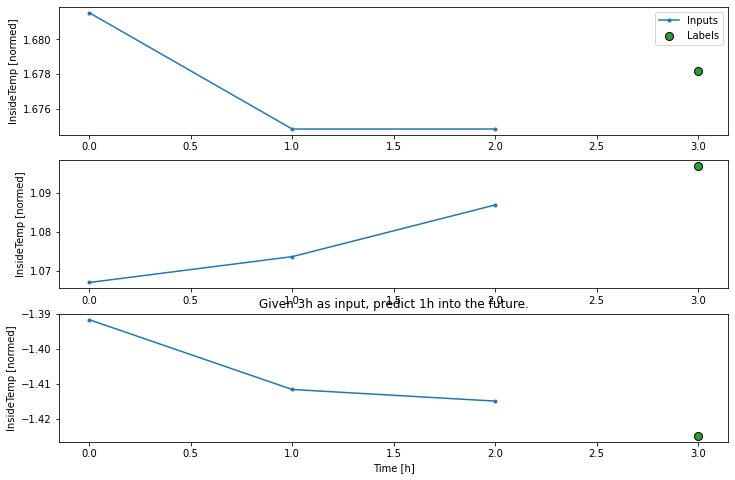

In [54]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [55]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [56]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [57]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)


509/509 [==============================] - 0s 903us/step - loss: 0.0090 - mean_absolute_error: 0.0701


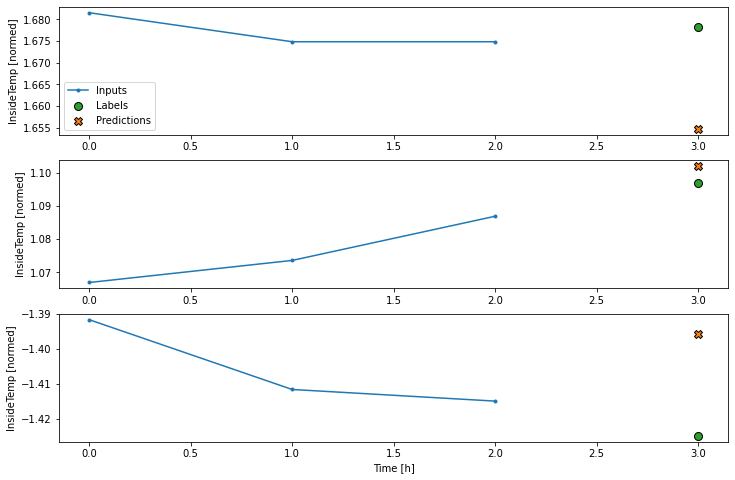

In [58]:
conv_window.plot(multi_step_dense)


In [59]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')


Input shape: (32, 15, 7)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,105], In[1]: [21,32] [Op:MatMul]


### Convolution neural network

In [60]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [61]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [62]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)


509/509 [==============================] - 0s 953us/step - loss: 0.0357 - mean_absolute_error: 0.1516


In [63]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 15, 7)
Labels shape: (32, 15, 1)
Output shape: (32, 13, 1)


In [64]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['InsideTemp'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['InsideTemp']

In [65]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (32, 26, 7)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


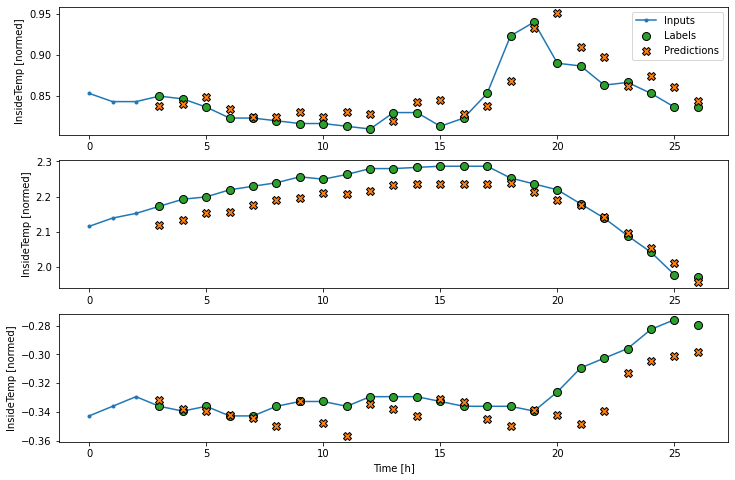

In [66]:
wide_conv_window.plot(conv_model)


### Recurrent neural network

In [67]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [68]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


Input shape: (32, 15, 7)
Output shape: (32, 15, 1)


In [69]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


509/509 [==============================] - 1s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0466


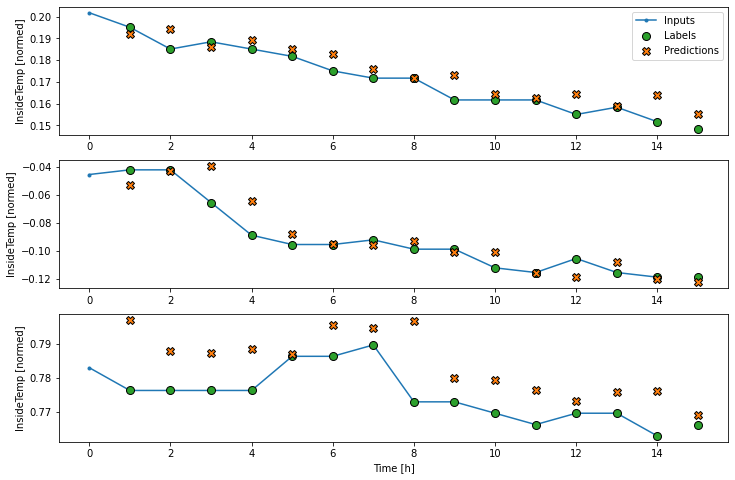

In [70]:
wide_window.plot(lstm_model)


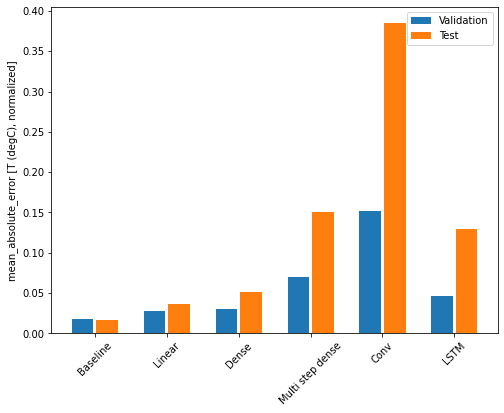

In [71]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [72]:
for name, value in performance.items():
  print(f'{name:20s}: {value[1]:0.4f}')


Baseline            : 0.0164
Linear              : 0.0360
Dense               : 0.0518
Multi step dense    : 0.1500
Conv                : 0.3855
LSTM                : 0.1288


### Multi-output models

In [73]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 24, 7)
Labels shape (batch, time, features): (32, 24, 7)


In [74]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


In [75]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)


509/509 [==============================] - 0s 943us/step - loss: 0.0017 - mean_absolute_error: 0.0158


In [76]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])


In [77]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


509/509 [==============================] - 1s 983us/step - loss: 0.0197 - mean_absolute_error: 0.0979


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()


Epoch 1/20
1781/1781 [==============================] - 14s 8ms/step - loss: 0.0501 - mean_absolute_error: 0.1092 - val_loss: 0.0584 - val_mean_absolute_error: 0.1643
Epoch 2/20
1781/1781 [==============================] - 13s 7ms/step - loss: 0.0038 - mean_absolute_error: 0.0276 - val_loss: 0.0327 - val_mean_absolute_error: 0.1182
Epoch 3/20
1781/1781 [==============================] - 13s 7ms/step - loss: 0.0026 - mean_absolute_error: 0.0191 - val_loss: 0.0245 - val_mean_absolute_error: 0.0984
Epoch 4/20
 773/1781 [============>.................] - ETA: 6s - loss: 0.0025 - mean_absolute_error: 0.0172

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()


In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')


## Multi-step models

### baseline

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)


In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)


In [ ]:
### Single-shot models

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)


In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)



In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(multi_lstm_model)


In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()


In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')
